In [1]:
import sys
sys.path.insert(0,'..')
from paths import *
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
from tqdm import tqdm
from scipy.stats import ttest_ind

from IPython.display import clear_output


/Users/karthiksoman/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Load untargeted metabolomics data

In [2]:
sample = "feces"

if sample == "serum":
    filename = GLOBAL_SERUM_DATA_FILENAME
else:
    filename = GLOBAL_STOOL_DATA_FILENAME
    

file_path = os.path.join(DATA_ROOT_PATH, filename)

sheet_name = ["Chemical Annotation", "Sample Meta Data", "Log Transformed Data"]

analyte_metadata = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[0])
patient_metadata = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[1])
data = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[2])

data.head()

patient_metadata.loc[:, "site_code"] = patient_metadata["CLIENT_SAMPLE_ID"].apply(lambda x:x[0:3])



## Analyte selection

In [3]:
global_metabolomics_compound_spoke_map = pd.read_csv(os.path.join(os.path.dirname(OUTPUT_PATH), "global_metabolomics_compound_spoke_map.csv"))

analyte_columns = list(data.columns)
analyte_columns.remove("PARENT_SAMPLE_NAME")

analyte_columns_selected = global_metabolomics_compound_spoke_map[global_metabolomics_compound_spoke_map.CHEM_ID.isin(analyte_columns)]["CHEM_ID"].unique()

data_with_analyte_columns_selected = data[["PARENT_SAMPLE_NAME"]+list(analyte_columns_selected)]


## Merging patient metadata with analyte concentration data

In [4]:
selected_metadata_columns = ["PARENT_SAMPLE_NAME", "CLIENT_IDENTIFIER", "GROUP_NAME", "AGE", "BMI", "GENDER", "CLIENT_SAMPLE_ID", "CLIENT_MATRIX", "TREATMENT", "SAMPLE_AMOUNT_UNITS"]
patient_metadata_selected_columns = patient_metadata[selected_metadata_columns]
patient_metadata_selected_columns.loc[:, 'house'] = (patient_metadata_selected_columns['CLIENT_SAMPLE_ID'].str[:3] + patient_metadata_selected_columns['CLIENT_SAMPLE_ID'].str[-4:])
patient_metadata_selected_columns.loc[:, 'site'] = patient_metadata_selected_columns.loc[:, 'CLIENT_SAMPLE_ID'].str[:3]


data_with_patient_metadata = pd.merge(data_with_analyte_columns_selected, patient_metadata_selected_columns, on="PARENT_SAMPLE_NAME")

selected_metadata_columns.append('site')

clear_output()

data_with_patient_metadata.head()



,PARENT_SAMPLE_NAME,35,50,62,93,98,111,112,144,158,...,GROUP_NAME,AGE,BMI,GENDER,CLIENT_SAMPLE_ID,CLIENT_MATRIX,TREATMENT,SAMPLE_AMOUNT_UNITS,house,site
0,UCSF-07758,0.023685,-0.992358,0.081437,1.225531,1.439210,-1.336249,-0.044492,0.906045,-2.241044,...,Control,32.0,18.426534,F,71802-0027,feces,Control,ug,7180027,718
1,UCSF-07759,0.166186,-0.094343,2.291841,0.394435,1.246446,-0.067657,1.480448,0.891433,0.079749,...,Control,44.0,19.843750,F,71702-0164,feces,Control,ug,7170164,717
2,UCSF-07760,0.465597,-1.197209,-1.401667,1.095159,1.556548,-1.543398,0.210838,0.647214,-1.386518,...,Control,34.0,23.685228,F,71602-0131,feces,Control,ug,7160131,716
3,UCSF-07761,-0.375407,-2.276426,-3.918197,-1.385966,-1.021095,-1.543398,-0.053911,-0.691927,-2.241044,...,Control,65.0,33.388778,F,71702-0214,feces,Control,ug,7170214,717
4,UCSF-07762,0.340142,-0.125123,0.211002,1.791118,1.316333,0.284801,1.346525,2.621563,-2.241044,...,Control,29.0,28.133657,F,71802-0168,feces,Control,ug,7180168,718


## Load patient ids shared by Jorge Correale

In [5]:
tcell_patient_ids = pd.read_excel(os.path.join(DATA_ROOT_PATH, 'tcell_data', 'patients_selected_by_Jorge_Correale.xlsx'), engine='openpyxl')
tcell_patient_ids_list = list(tcell_patient_ids.Patients) + list(tcell_patient_ids.Controls)
tcell_patient_ids_list = list(pd.DataFrame(tcell_patient_ids_list, columns=['patient_id']).dropna().patient_id)

tcell_patient_data = data_with_patient_metadata[data_with_patient_metadata.CLIENT_SAMPLE_ID.isin(tcell_patient_ids_list)]


## Get CHEM ID for riboflavin

In [6]:
riboflavin_chem_id = analyte_metadata[analyte_metadata['CHEMICAL_NAME'].str.contains('riboflavin')].CHEM_ID.values[0]
riboflavin_chem_id

500

In [7]:
analyte_metadata[analyte_metadata['CHEMICAL_NAME'].str.contains('Vit')]



,CHEM_ID,LIB_ID,COMP_ID,CHRO_LIB_ENTRY_ID,SUPER_PATHWAY,SUB_PATHWAY,PATHWAY_SORTORDER,TYPE,INCHIKEY,SMILES,CHEMICAL_NAME,PLOT_NAME,CAS,CHEMSPIDER,HMDB,KEGG,PUBCHEM,PLATFORM


## Separate MS and Control group and get their Riboflavin levels

In [8]:
tcell_patient_data_ms = tcell_patient_data[tcell_patient_data['GROUP_NAME']=='MS']
tcell_patient_data_control = tcell_patient_data[tcell_patient_data['GROUP_NAME']=='Control']

tcell_patient_data_ms_riboflavin = list(tcell_patient_data_ms[riboflavin_chem_id])
tcell_patient_data_control_riboflavin = list(tcell_patient_data_control[riboflavin_chem_id])

# tcell_patient_data_ms_riboflavin = np.exp(tcell_patient_data_ms_riboflavin)
# tcell_patient_data_control_riboflavin = np.exp(tcell_patient_data_control_riboflavin)


## t-test of 2 groups

In [9]:

t_stat, p_val = ttest_ind(tcell_patient_data_ms_riboflavin, tcell_patient_data_control_riboflavin)

if p_val < 0.001:
    stars = '***'
elif p_val < 0.01:
    stars = '**'
elif p_val < 0.05:
    stars = '*'
else:
    stars = 'ns'


## Box plot of Riboflavin level for 2 groups

/Users/karthiksoman/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:gray'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/karthiksoman/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/karthiksoman/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/karthiksoman/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a

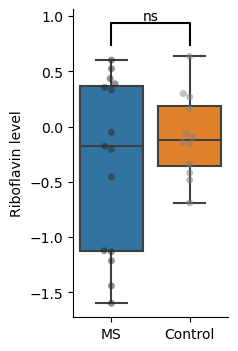

Saving the figure ...


In [10]:

fig, ax = plt.subplots(figsize=(2, 4))

riboflavin_data_combined = [tcell_patient_data_ms_riboflavin, tcell_patient_data_control_riboflavin]

sns.boxplot(data=riboflavin_data_combined, ax=ax, showfliers=False)
sns.swarmplot(data=riboflavin_data_combined, color='gray', alpha=0.5, ax=ax, marker='o')
ax.set_xticklabels(['MS', 'Control'])

y, h, col = max(max(riboflavin_data_combined[0]), max(riboflavin_data_combined[1])) + .1, 0.2, 'k'
plt.plot([0, 0, 1, 1], [y, y+h, y+h, y], lw=1.5, color=col)
plt.text((0 + 1) * .5, y + h, stars, ha='center', va='bottom', color=col)
plt.ylabel('Riboflavin level')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

print('Saving the figure ...')
fig_filename = os.path.join(DATA_ROOT_PATH, 'tcell_data', 'figures', f'box_plot_{sample}.tiff')
fig.savefig(fig_filename, format='tiff', bbox_inches='tight')



In [11]:
p_val

0.3558312701023374

In [12]:
df_1 = pd.merge(tcell_patient_ids, tcell_patient_data_ms, left_on='Patients', right_on='CLIENT_SAMPLE_ID')

df_2 = pd.merge(df_1, tcell_patient_data_control, left_on='Controls', right_on='CLIENT_SAMPLE_ID')


In [13]:
df_3 = df_2[['Patients', 'Controls']+[str(riboflavin_chem_id)+'_x', str(riboflavin_chem_id)+'_y']]
df_3

,Patients,Controls,500_x,500_y
0,71801-0002,71802-0005,0.601233,-0.689718
1,71801-0003,71802-0006,0.523558,-0.095791
2,71801-0013,71802-0010,-1.597964,-0.417641
3,71801-0017,71802-0011,0.434001,0.298686
4,71801-0020,71802-0012,-0.205326,0.162480
5,71801-0023,71802-0015,-1.131582,-0.340699
6,71801-0032,71802-0021,0.386817,-0.140426
7,71801-0035,71802-0031,-0.052182,-0.483760
8,71801-0038,71802-0046,-1.213687,-0.153122
9,71801-0041,71802-0052,-0.453953,0.634642


/var/folders/p1/h56gxdhs5vgb0ztp7h4z606h0000gn/T/ipykernel_88619/253726988.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.stripplot(data=[df_3['Patients'], df_3['Controls']], jitter=True, palette='Set2')


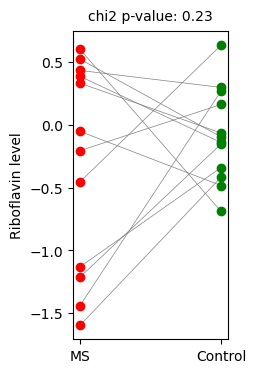

Saving the figure ...


In [14]:
from scipy.stats import chi2_contingency


contingency_table = pd.crosstab(df_3['500_x'], df_3['500_y'])
chi2, p, dof, expected = chi2_contingency(contingency_table)


fig = plt.figure(figsize=(2, 4))

sns.stripplot(data=[df_3['Patients'], df_3['Controls']], jitter=True, palette='Set2')

for i in range(df_3.shape[0]):
    plt.plot([0, 1], [df_3['500_x'].iloc[i], df_3['500_y'].iloc[i]], color='gray', linestyle='-', linewidth=0.5)
    plt.scatter(0, df_3['500_x'].iloc[i], color='red', zorder=3)
    plt.scatter(1, df_3['500_y'].iloc[i], color='green', zorder=3)
    
plt.xticks([0, 1], ['MS', 'Control'])
plt.ylabel('Riboflavin level')
# plt.title('Patient and Control Data with Connections between 500_x and 500_y')

plt.text(0.5, max(max(df_3['500_x']), max(df_3['500_y'])) + 0.2, f'chi2 p-value: {p:.2f}', ha='center')

plt.show()

print('Saving the figure ...')
fig_filename = os.path.join(DATA_ROOT_PATH, 'tcell_data', 'figures', f'strip_plot_{sample}.tiff')
fig = fig.savefig(fig_filename, format='tiff', bbox_inches='tight')

